# Deepfake Image Detection

Autori: Bucă Mihnea-Vicențiu; Căpatână Răzvan-Nicolae; Luculescu Teodor


## Cross-generator deepfake detection

We want to evaluate the generalization capabilities of deepfake detection methods: how well detectors work when tested on images produced by other generators than those seen at training. For this, we will train on images coming from one generator and test on images coming from other generators. We will compare at least three different methods.

First method:
- We will use an image classification architecture, mainly XceptionNet, that will be trained from scratch.


Second method:
- The same architecture as above, but this time initialized with pre-trained weights. The weights will be obtained by supervised learning (image classification on ImageNet).


Third method:
- Large pretrained self-supervised representations followed by a linear classifier. In this case, only the linear classifier is trained; the representations are extracted with a frozen model. [Ojha et al., (2023)](https://github.com/WisconsinAIVision/UniversalFakeDetect) have used this approach in the context of deepfake detection, but differently from us, they have applied it to general fully-generated images. We will train two models, one using CLIP and one using SAM self-supervised representations and compare the results obtained.


For each method, fill in a table with the average precisions.

In this notebook we will use the **First method**

### Data

The dataset can be downloaded from [here](https://drive.google.com/file/d/1NfLX9bZtOY8dO_yj3cU7pEHGmqItqjg2/view). It contains real images from the CelebAHQ dataset and locally manipulated images produced by four generators: [LDM](https://github.com/CompVis/latent-diffusion), [Pluralistic](https://github.com/lyndonzheng/Pluralistic-Inpainting), [LAMA](https://github.com/advimman/lama), [Repaint](https://github.com/andreas128/RePaint). You can read more about how this dataset was produced in Section 3.3 of the following paper:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We will extract the data for each model

In [ ]:
import zipfile
import os

# path to the zip file
zip_file_path = 'drive/MyDrive/Proiect DeepLearning/DeepFMI_local_data.zip'

# the paths to the datasets within the zip file
dataset_paths = [
    'FMI_local_data/celebhq_real_data',
    'FMI_local_data/lama',
    'FMI_local_data/ldm',
    'FMI_local_data/pluralistic',
    'FMI_local_data/repaint'
]

# create a ZipFile object
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Iterate through the dataset paths
    for dataset_path in dataset_paths:
         zip_ref.extractall(members=[
            name for name in zip_ref.namelist()
            if name.startswith(dataset_path)
        ], path='/content/')  # Extract to the '/content/' directory


## Training Models

In [ ]:
# important libraries
import torch
import glob
import pandas as pd
import torch.nn as nn
import torch.optim as optim

import numpy as np

import timm
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import display, Markdown
from sklearn.metrics import average_precision_score
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.models as models
from PIL import Image
from tqdm import tqdm  # for progress bar

In [ ]:
class DeepFakeDataset(Dataset):
    """
    Takes two folders (real vs fake) and assigns labels 0 / 1.
    """
    def __init__(self, real_folder: str, fake_folder: str, transform=None):
        # grab all .png under each
        self.real_paths = sorted(glob.glob(os.path.join(real_folder, '*.png')))
        self.fake_paths = sorted(glob.glob(os.path.join(fake_folder, '*.png')))

        # create a single list of (path, label)
        # real = 0, fake = 1
        self.samples = (
            [(p, 0) for p in self.real_paths] +
            [(p, 1) for p in self.fake_paths]
        )
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
def make_model_dataloaders(
    root_dir: str,            # contains subfolders: lama/, ldm/, repaint/, pluralistic/
    real_root: str,           # path to celebhq_real_data
    model_names: list[str],   # ['lama','ldm','repaint','pluralistic']
    splits: list[str] = ('train','valid','test'),
    batch_size: int = 16,
    img_size: int = 256,
    num_workers: int = 2
):
    """
    Returns a dict:
      { model_name: { split: DataLoader, … }, … }
      Each loader mixes real vs that model's fake images.
    """

    # strong augmentation for train
    train_tf = transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465), (0.2023,0.1994,0.2010))
    ])

    # weak augmentation for val/test
    test_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465), (0.2023,0.1994,0.2010))
    ])

    dataloaders = {}
    for model_name in model_names:
            dataloaders[model_name] = {}
            for split in splits:
                real_folder = os.path.join(real_root, split)
                fake_folder = os.path.join(root_dir, model_name, split)

                tf = train_tf if split=='train' else test_tf
                ds = DeepFakeDataset(real_folder, fake_folder, transform=tf)

                dataloaders[model_name][split] = DataLoader(
                    ds,
                    batch_size=batch_size,
                    shuffle=(split=='train'),
                    num_workers=num_workers,
                    pin_memory=True
                )

    return dataloaders

In [ ]:
root = "/content/FMI_local_data"
deepfake_models = ["lama", "ldm", "repaint", "pluralistic"]
loaders = make_model_dataloaders(
    root_dir=root,
    real_root=os.path.join(root, "celebhq_real_data"),
    model_names=deepfake_models,
    splits=['train', 'valid', 'test'],
    batch_size=16,
    img_size=256,
    num_workers=2
)

# test
ldm_train_loader = loaders['ldm']['train']
print(f"ldm train batches: {len(ldm_train_loader)}")

ldm train batches: 1125


In [ ]:
def train_timm_scratch_one_epoch(
    dataloaders: dict,
    model_name: str = 'xception41',
    num_classes: int = 2,
    lr: float = 1e-3,
    device: str = None
):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    results = {}

    for name, splits in dataloaders.items():
        print(f"\n=== Training {model_name} from scratch on '{name}' (1 epoch) ===")

        # 1) instantiate model without pretrained weights
        model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
        model = model.to(device)

        # 2) loss & optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # 3) Single training epoch
        model.train()
        running_loss = 0.0
        for imgs, labels in splits['train']:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(imgs)             # raw logits
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        avg_loss = running_loss / len(splits['train'].dataset)
        print(f"  Train 1-epoch loss: {avg_loss:.4f}")

        # 4) Validation
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for imgs, labels in splits['valid']:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs).argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        valid_acc = correct / total
        print(f"  Valid accuracy: {valid_acc:.4%}")


        results[name] = {
            'model': model,
            'valid_acc': valid_acc,
        }

        # clear GPU memory
        torch.cuda.empty_cache()

    return results

In [ ]:
results = train_timm_scratch_one_epoch(
    dataloaders=loaders,
    model_name='xception41',
    num_classes=2,
    lr=1e-3
)


=== Training xception41 from scratch on 'lama' (1 epoch) ===
  Train 1-epoch loss: 0.7056
  Valid accuracy: 59.2778%

=== Training xception41 from scratch on 'ldm' (1 epoch) ===
  Train 1-epoch loss: 0.7077
  Valid accuracy: 50.0556%

=== Training xception41 from scratch on 'repaint' (1 epoch) ===
  Train 1-epoch loss: 0.7104
  Valid accuracy: 50.0000%

=== Training xception41 from scratch on 'pluralistic' (1 epoch) ===
  Train 1-epoch loss: 0.6863
  Valid accuracy: 53.1111%


In [ ]:
# save models in drive/MyDrive/Proiect DeepLearning/Task-1/First-Method
save_path = 'drive/MyDrive/Proiect DeepLearning/Task-1/First-Method/results.pth'
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Ensure the directory exists
torch.save(results, save_path)
print(f"Results saved to: {save_path}")

Results saved to: drive/MyDrive/Proiect DeepLearning/First-Method/results.pth


In [ ]:
def build_cross_table_ap(results: dict, dataloaders: dict, device=None) -> pd.DataFrame:
    """
    Returns a cross-table with average precision score (macro-averaged).
    Assumes classification with multiple classes.
    """
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    gens = list(results.keys())
    table = pd.DataFrame(index=gens, columns=gens, dtype=float)

    for train_gen, result_dict in results.items():
        model = result_dict['model']
        model.to(device).eval()

        with torch.no_grad():
            for test_gen in gens:
                all_probs = []
                all_targets = []
                for imgs, labels in dataloaders[test_gen]['test']:
                    imgs = imgs.to(device)
                    logits = model(imgs)  # raw outputs
                    probs = torch.softmax(logits, dim=1).cpu().numpy()
                    all_probs.append(probs)
                    all_targets.append(labels.cpu().numpy())

                all_probs = np.concatenate(all_probs, axis=0)
                all_targets = np.concatenate(all_targets, axis=0)

                # Convert labels to one-hot
                num_classes = all_probs.shape[1]
                targets_onehot = np.eye(num_classes)[all_targets]

                ap_score = average_precision_score(targets_onehot, all_probs, average='macro')
                table.loc[test_gen, train_gen] = ap_score

    return table

In [ ]:
# torch.serialization.add_safe_globals([timm.models.xception_aligned.XceptionAligned])
# tmp = torch.load('drive/MyDrive/Proiect DeepLearning/Task-1/First-Method/results.pth', weights_only=False)
df = build_cross_table_ap(results, loaders)
print("\nCross-Generator Accuracy Table:\n")
display(Markdown(df.to_markdown(floatfmt=".3f")))


Cross-Generator Accuracy Table:



|             |   lama |   ldm |   repaint |   pluralistic |
|:------------|-------:|------:|----------:|--------------:|
| lama        |  0.641 | 0.493 |     0.536 |         0.517 |
| ldm         |  0.569 | 0.496 |     0.511 |         0.536 |
| repaint     |  0.572 | 0.487 |     0.517 |         0.531 |
| pluralistic |  0.667 | 0.491 |     0.580 |         0.700 |

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
torch.serialization.add_safe_globals([timm.models.xception_aligned.XceptionAligned])
# Load the model and map to the appropriate device
tmp = torch.load('drive/MyDrive/Proiect DeepLearning/First-Method/results.pth', map_location=torch.device(device), weights_only=False)

Using device: cpu


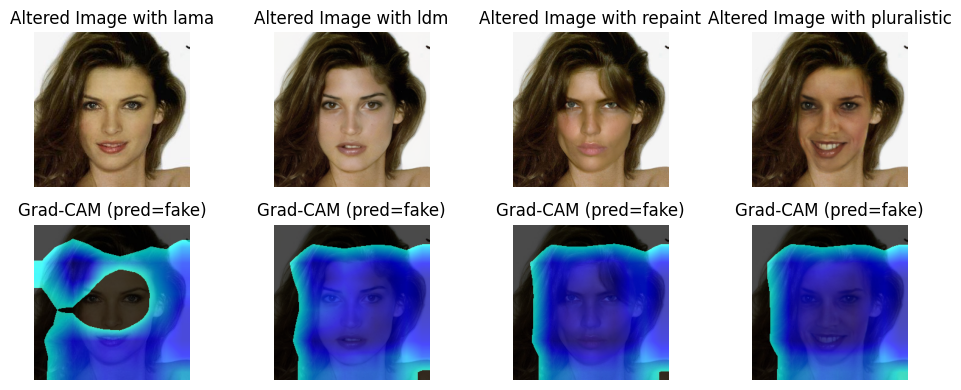

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import cv2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1) Load pluralistic model & hook last conv
last_model_key = list(tmp.keys())[-1]
model = tmp[last_model_key]['model']
target_layer = model._modules.get(list(model._modules)[-2])

class GradCAM:
    def __init__(self, model, layer):
        self.model = model
        self.layer = layer
        self.grad  = None
        layer.register_backward_hook(lambda m, gi, go: setattr(self, 'grad', go[0].detach()))

    def __call__(self, x, class_idx=1):
        fmap = None
        hook = self.layer.register_forward_hook(lambda m, i, o: setattr(self, 'fmap', o.detach()))
        logits = self.model(x)
        hook.remove()
        self.model.zero_grad()
        logits[0, class_idx].backward(retain_graph=True)
        grads = self.grad[0]          # (C,H,W)
        fmap  = self.fmap[0]          # (C,H,W)
        weights = grads.view(grads.size(0), -1).mean(1)
        cam = (weights[:,None,None] * fmap).sum(0).relu()
        cam = (cam - cam.min())/(cam.max()-cam.min())
        return cam.cpu().numpy()

gradcam = GradCAM(model, target_layer)

# 2) Grab one fake=1 example per domain (true RGB)
domains = ['lama','ldm','repaint','pluralistic']
orig_paths = []
for d in domains:
    ds = loaders[d]['test'].dataset
    # ds.samples is list of (path, label)
    for path, label in ds.samples:
        if label == 1:
            orig_paths.append(path)
            break

originals = [Image.open(p).convert('RGB') for p in orig_paths]

# 3) Preprocessing for model input only
preproc = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,)*3, std=(0.5,)*3)
])

# 4) Overlay in red on original RGB
def overlay_strong(orig_np: np.ndarray, cam: np.ndarray,
                   thresh: float = 0.6, alpha: float = 0.7) -> np.ndarray:
    """
    orig_np: H×W×3 uint8 RGB image
    cam:     h×w float in [0,1]
    thresh:  cutoff (0–1) to pick the strongest CAM regions
    alpha:   blending factor
    """
    # Resize CAM to match image size
    cam_resized = cv2.resize(cam, (orig_np.shape[1], orig_np.shape[0]))

    # Normalize cam_resized to [0, 255] for colormap
    cam_uint8 = np.uint8(255 * cam_resized)
    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)

    # Mask out low-activation regions
    mask = cam_resized >= thresh
    heatmap[~mask] = 0  # zero out weak activations

    # Blend with original image
    blended = cv2.addWeighted(orig_np, 1 - alpha, heatmap, alpha, 0)

    return blended
# 5) Plot
fig, axes = plt.subplots(2, len(domains), figsize=(10, len(domains)))
for i, img in enumerate(originals):
    # show truly unaltered PNG
    orig_np = np.array(img)
    axes[0, i].imshow(orig_np)
    axes[0, i].set_title(f"Altered Image with {domains[i]}")
    axes[0, i].axis('off')

    # prepare for model
    x = preproc(img).unsqueeze(0).to(device)
    logits = model(x)
    pred = torch.argmax(logits, dim=1).item()
    cam = gradcam(x)  # your GradCAM instance
    blended = overlay_strong(orig_np, cam)

    pred_label = 'fake' if pred == 1 else 'real'
    axes[1, i].imshow(blended)
    axes[1, i].set_title(f"Grad-CAM (pred={pred_label})")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()